In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
#         self.data_rho = h.mean(0)
        self.data_rho = ((F.softmax(h, dim=1)*rho*len(h)/(rho + len(h)))).mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
#         dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - torch.log(self.data_rho) * rho - torch.log((1 - self.data_rho)) * (1 - rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.938071 32: 0.937959 64: 0.945212
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.316466 32: 0.289663 64: 0.272795
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.254826 32: 0.247782 64: 0.246467
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.257868 32: 0.232991 64: 0.233156
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.256315 32: 0.234694 64: 0.228763
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.238843 32: 0.206323 64: 0.193302
Test set:
16: loss: 0.2301	rho_loss: 0.0058
32: loss: 0.1987	rho_loss: 0.0065
64: loss: 0.1859	rho_loss: 0.0072

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.245544 32: 0.212937 64: 0.202526
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.202966 32: 0.172606 64: 0.158128
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.183425 32: 0.159383 64: 0.147660
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.190297 32: 0.170625 64: 0.158855
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.164326 32: 0.146959 64: 0.133708
Train

Test set:
16: loss: 0.0881	rho_loss: 0.0058
32: loss: 0.0621	rho_loss: 0.0065
64: loss: 0.0527	rho_loss: 0.0072

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.084299 32: 0.061538 64: 0.053049
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.098913 32: 0.067793 64: 0.057109
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.090398 32: 0.063700 64: 0.052812
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.091605 32: 0.062544 64: 0.052995
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.081669 32: 0.055075 64: 0.047262
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.083700 32: 0.057231 64: 0.047396
Test set:
16: loss: 0.0870	rho_loss: 0.0058
32: loss: 0.0602	rho_loss: 0.0065
64: loss: 0.0508	rho_loss: 0.0072

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.082308 32: 0.057142 64: 0.048252
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.086717 32: 0.058306 64: 0.049493
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.079210 32: 0.053451 64: 0.045425
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [9]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([57, 47, 58, 53, 55, 57, 52, 52, 47, 51, 52, 51, 55, 49, 51, 46, 54, 52,
        43, 59, 55, 54, 52, 56, 58, 41, 52, 54, 49, 53, 54, 54, 50, 48, 53, 45,
        55, 52, 57, 56, 61, 56, 55, 55, 55, 57, 51, 54, 51, 52])


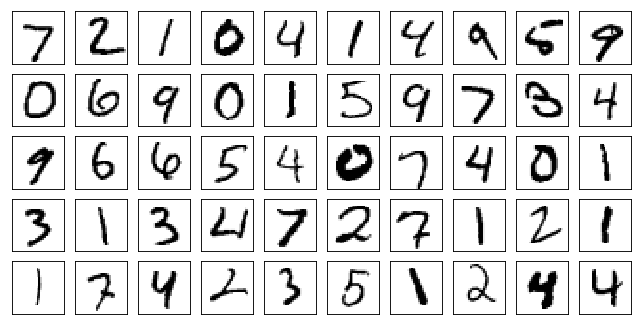

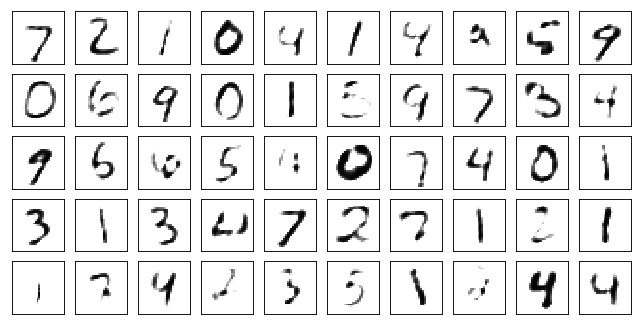

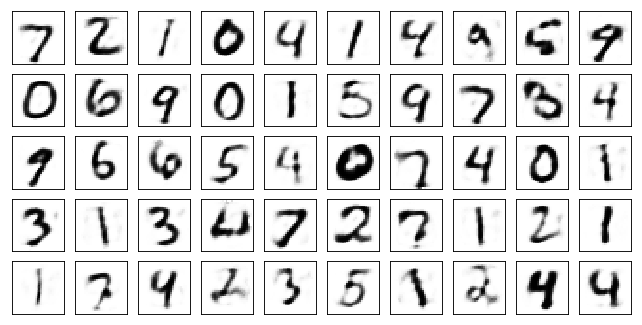

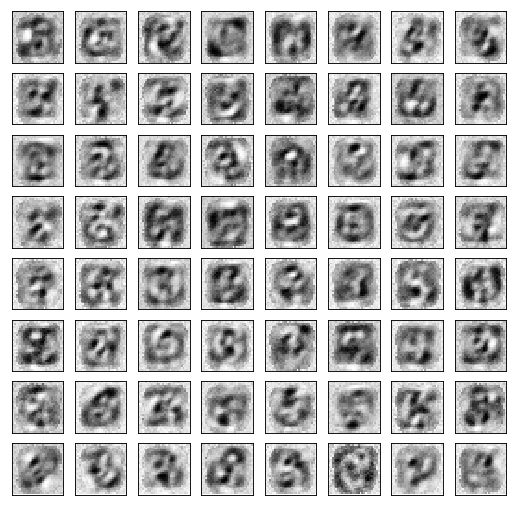

In [10]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

In [11]:
h = torch.tensor([[1.,2.,1.],[0.,2.,1.]])


In [12]:
h.size()

torch.Size([2, 3])

In [13]:
h.mean(0)

tensor([0.5000, 2.0000, 1.0000])

In [14]:
F.softmax(h, dim=1)

tensor([[0.2119, 0.5761, 0.2119],
        [0.0900, 0.6652, 0.2447]])

In [15]:
torch.sum(F.softmax(h, dim=1))

tensor(2.)

In [16]:
k = h.mean(0); k

tensor([0.5000, 2.0000, 1.0000])

In [17]:
(F.softmax(h, dim=1)*rho/(rho + len(h))).size()

torch.Size([2, 3])

In [18]:
(F.softmax(h, dim=1)*rho/(rho + len(h))).mean(0).size()

torch.Size([3])

In [19]:
((F.softmax(h, dim=1)*rho/(rho + len(h)))).size()

torch.Size([2, 3])

In [20]:
torch.sum((F.softmax(h, dim=1)*rho/(rho + len(h))))

tensor(0.0488)

In [21]:
rho

0.05

In [22]:
torch.backends.cudnn.enabled

True